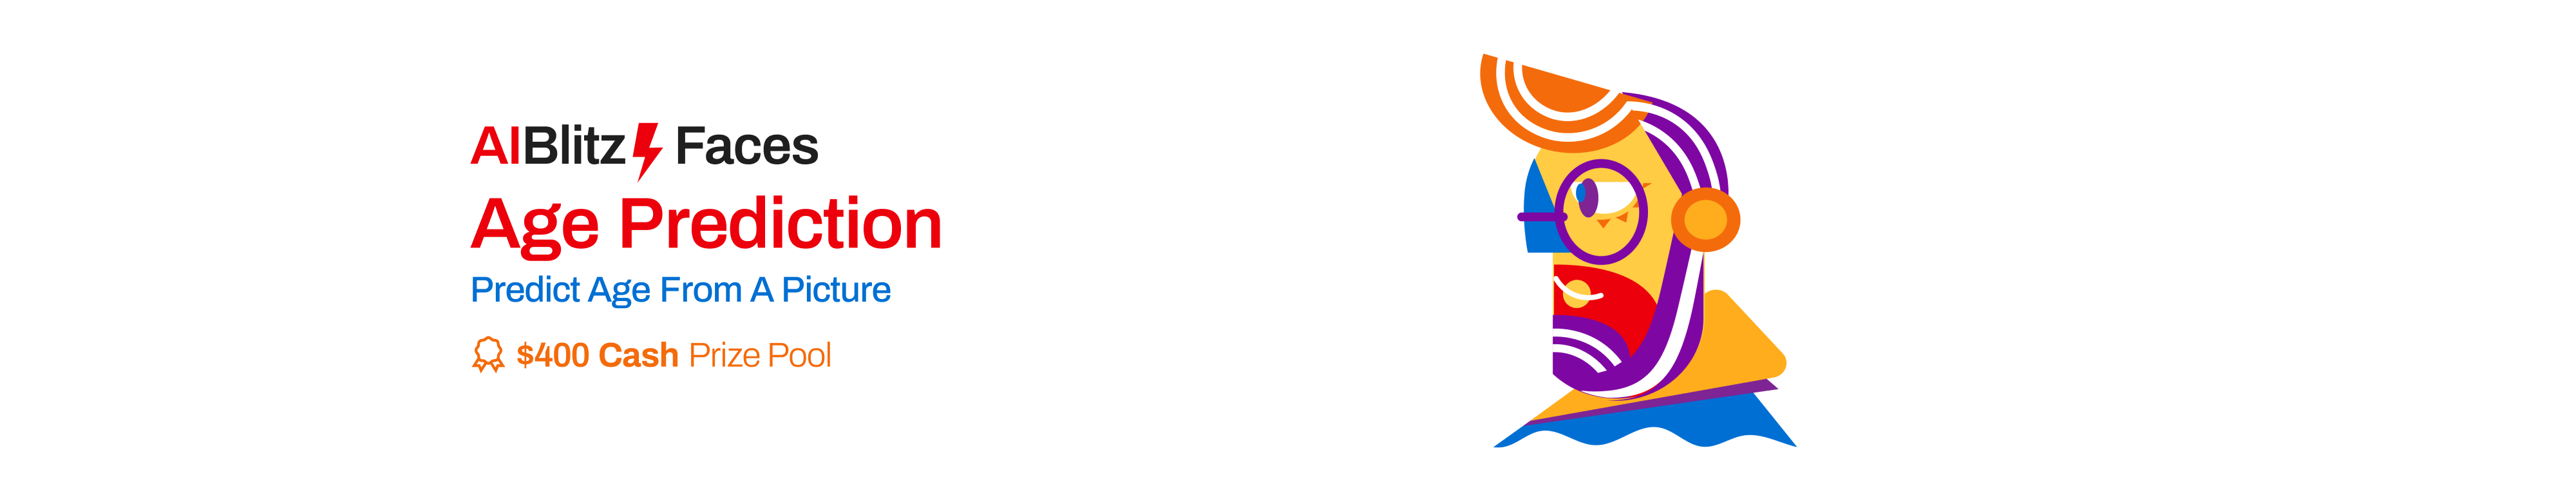

<h2><center> Getting Started with Age Prediction</center></h2>

In this puzzle, we have to predict the age from the given human faces.

This is a starter kit explaining how to download the data and also submit direcly via this notebook. 

In this baseline, we are going to reduce the number of pixels, take them out in a list, and are going to use a random forest classifier model.






# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [1]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



## Login to AIcrowd ㊗¶


## Download Dataset¶

We will create a folder name data and download the files there.

In [2]:
import os
os.getcwd()

'/home/kuba/Projects/aicrowd/blitzxiii'

!mkdir data
%aicrowd ds dl -c age-prediction -o data

!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

## Importing Libraries:

In [3]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Diving in the dataset 🕵️‍♂️

In [4]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/sample_submission.csv")

In [5]:
print(train_df.head(3))

  ImageID     age
0   93vu1   30-40
1   yjifi   80-90
2   ldd2k  90-100


The number of datapoints in train is 4000
The number of datapoints in valid is 2000
The number of datapoints in test is 3000

In [6]:
print(train_df.shape[0])
print(val_df.shape[0])
print(test_df.shape[0])

4000
2000
3000


In [7]:
train_df

,ImageID,age
0,93vu1,30-40
1,yjifi,80-90
2,ldd2k,90-100
3,eiwe0,40-50
4,sc0bp,0-10
...,...,...
3995,y3276,20-30
3996,rqegl,0-10
3997,nfa2a,90-100
3998,ngoz1,30-40


The target labels are '0-10' to '90-100'. So there are 10 target labels.

In [8]:
train_df['age'].unique()

array(['30-40', '80-90', '90-100', '40-50', '0-10', '60-70', '70-80',
       '20-30', '50-60', '10-20'], dtype=object)

## Modeling
We are going to use a very naive approach here.

We will be reducing the number of pixels, take them out in a list, and then use a random forest classifier model.

In [9]:
from pathlib import Path


def create_item_metadata(image_path, row):
    item_metadata = {
        'image_path': str(Path(image_path) / (row['ImageID'] + ".jpg")),
        'namedboxes': [],
        'namedmasks': [],
        'namedkeypoints': [],
        'image_classnames': [row['age']]
    }
    return item_metadata

In [10]:
def create_dsvision_metadata(image_path, metadata_df):
    items = []
    for idx, row in metadata_df.iterrows():
        item_metadata = create_item_metadata(image_path, row) 
        items.append(item_metadata)
    return items

In [11]:
train_metadata_df = create_dsvision_metadata('data/train', train_df)
val_metadata_df = create_dsvision_metadata('data/val', val_df)

In [12]:
train_df['age'].unique()

array(['30-40', '80-90', '90-100', '40-50', '0-10', '60-70', '70-80',
       '20-30', '50-60', '10-20'], dtype=object)

In [13]:
from deepsense_vision.datasets.deepsense_dataset import DeepsenseDataset
import json

In [14]:
json.dump(train_metadata_df, open("train_metadata.json", "w"))
json.dump(val_metadata_df, open("val_metadata.json", "w"))

In [15]:
classes = list(train_df['age'].unique())

In [16]:
train_transformations=["resize(128, 128)"],

TRAIN_DATA_DIR = "data/train"
train_dataset = DeepsenseDataset(
    "train_metadata.json",
    classnames=classes,
    mask_level=None
)

DeepsenseDataset: loading annotations...
DeepsenseDataset: 4000 annotations (0 namedboxes + 0 namedmasks + 0 namedkeypoints + 4000 image classnames) for 4000 metapoints loaded successfully!


In [17]:
val_dataset = DeepsenseDataset(
    "val_metadata.json",
    classnames=classes,
    mask_level=None
)

DeepsenseDataset: loading annotations...
DeepsenseDataset: 2000 annotations (0 namedboxes + 0 namedmasks + 0 namedkeypoints + 2000 image classnames) for 2000 metapoints loaded successfully!


In [18]:
import datetime

In [19]:
dt_str = str(datetime.datetime.now())[:-7].replace(" ", "-")

In [20]:
# %load ../../../work/test_mnist_training.py
import json
import os
from deepsense_vision.datasets.deepsense_dataset import DeepsenseDataset
from deepsense_vision.models.classifiers.classifier_config import ImageClassifierConfig
from deepsense_vision.models.classifiers.classifier_model import ImageClassifierModel

TRAIN_DATA_DIR = "data/train"
TEST_DATA_DIR = "data/val"

config = ImageClassifierConfig(
    model_type="GoogleNet",
    num_train_iters=500,
    valid_freq_iters=500,
    train_batch_size=16,
    valid_batch_size=32,
    num_input_channels=3,
    classnames=list(train_df['age'].unique()),
    train_transformations=["resize(224, 224)"],
    valid_transformations=["resize(224, 224)"],
    pretrained_model=True,
    lr_step_size=200,
    lr_gamma=0.9,
    experiment_dirpath="classification_default_experiment_directory" + dt_str
)

model = ImageClassifierModel()

In [21]:
import optuna
import json
import os

i = 0

In [22]:
i = 0

def train_dsvision_model(trial):
    dt_str = str(datetime.datetime.now())[:-7].replace(" ", "-")
    num_train_iters = trial.suggest_int("num_train_iters", 500, 5000, step=500)
    lr_step_size = trial.suggest_int("lr_step_size", 250, 1000, step=250)
    lr_gamma = trial.suggest_float("lr_gamma", 0.5, 0.99)
    print("num_train_iters: ", str(num_train_iters))
    print("lr_gamma: ", str(lr_gamma))
    print("lr_step_size: ", str(lr_step_size))
    experiment_path = "face_age_prediction_" + dt_str 
    config = ImageClassifierConfig(
        model_type="GoogleNet",
        num_train_iters=num_train_iters,
        valid_freq_iters=500,
        train_batch_size=16,
        valid_batch_size=32,
        num_input_channels=3,
        classnames=list(train_df['age'].unique()),
        train_transformations=["resize(224, 224)", "simple_augmentations(224, 224)"],
        valid_transformations=["resize(224, 224)"],
        pretrained_model=True,
        lr_step_size=lr_step_size,
        lr_gamma=lr_gamma,
        experiment_dirpath=experiment_path
    )
    model = ImageClassifierModel()
    model.train(train_dataset=train_dataset, valid_dataset=val_dataset, config=config)
    last_checkpoint_metrics_path = os.path.join(experiment_path, "checkpoint", "valid_metrics.json")
    metrics = json.load(open(last_checkpoint_metrics_path, "r"))
    f1 = metrics['global_macro']['f1']
    return f1

In [23]:
import optuna

In [24]:
study = optuna.create_study(direction="maximize")

[I 2022-02-10 11:53:03,588] A new study created in memory with name: no-name-9b4b5a0a-3247-46a9-8f92-b7a55f8f8667


In [25]:
study.optimize(train_dsvision_model, n_trials=50)

/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


num_train_iters:  1500
lr_gamma:  0.8945714379524207
lr_step_size:  500
load_state_dict_greedily: len(source_state_dict) = 344
load_state_dict_greedily: len(target_state_dict) = 344
load_state_dict_greedily: Initialized 344/344 tensors from source_state_dict successfully!
train_loss_values(iteration=100): loss_value_mean=1.410966, loss_value_max=2.397173, loss_value_std=0.352909
train_loss_values(iteration=200): loss_value_mean=1.078374, loss_value_max=1.530806, loss_value_std=0.203181
train_loss_values(iteration=300): loss_value_mean=0.967309, loss_value_max=1.633880, loss_value_std=0.221731
train_loss_values(iteration=400): loss_value_mean=0.900995, loss_value_max=1.745243, loss_value_std=0.238224


validation:   2%|▏         | 32/2000 [00:00<00:07, 250.58it/s]

train_loss_values(iteration=500): loss_value_mean=0.818687, loss_value_max=1.467477, loss_value_std=0.215895


validation: 100%|██████████| 2000/2000 [00:07<00:00, 252.46it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.558797   0.584221  0.571451                      
global_micro  0.581548   0.601556  0.598000                      
30-40         0.529101   0.543478  0.515464              100.0   
80-90         0.465517   0.515924  0.424084               81.0   
90-100        0.865140   0.781609  0.968661              340.0   
40-50         0.532995   0.512195  0.555556              105.0   
0-10          0.750656   0.680952  0.836257              143.0   
60-70         0.396341   0.511811  0.323383               65.0   
70-80         0.488599   0.714286  0.371287               75.0   
20-30         0.604027   0.482143  0.808383              135.0   
50-60         0.500000   0.451456  0.560241               93.0   
10-20         0.455598   0.648352  0.351190               59.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 248.57it/s]

train_loss_values(iteration=1000): loss_value_mean=0.685734, loss_value_max=1.547282, loss_value_std=0.227199


validation: 100%|██████████| 2000/2000 [00:08<00:00, 247.05it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.751797   0.759406  0.754523                      
global_micro  0.762054   0.771411  0.762000                      
30-40         0.782609   0.776650  0.788660              153.0   
80-90         0.643275   0.728477  0.575916              110.0   
90-100        0.900145   0.914706  0.886040              311.0   
40-50         0.703030   0.822695  0.613757              116.0   
0-10          0.822785   0.896552  0.760234              130.0   
60-70         0.671569   0.661836  0.681592              137.0   
70-80         0.705882   0.672646  0.742574              150.0   
20-30         0.827988   0.806818  0.850299              142.0   
50-60         0.673629   0.594470  0.777108              129.0   
10-20         0.787062   0.719212  0.869048              146.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 248.91it/s]

train_loss_values(iteration=1500): loss_value_mean=0.552964, loss_value_max=1.034130, loss_value_std=0.205129


validation: 100%|██████████| 2000/2000 [00:08<00:00, 249.47it/s]
[I 2022-02-10 11:56:37,529] Trial 0 finished with value: 0.7517973936424103 and parameters: {'num_train_iters': 1500, 'lr_step_size': 500, 'lr_gamma': 0.8945714379524207}. Best is trial 0 with value: 0.7517973936424103.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.625844   0.651602  0.635963                      
global_micro  0.645228   0.662068  0.662500                      
30-40         0.526971   0.440972  0.654639              127.0   
80-90         0.561873   0.777778  0.439791               84.0   
90-100        0.883249   0.796339  0.991453              348.0   
40-50         0.260606   0.304965  0.227513               43.0   
0-10          0.853333   0.784314  0.935673              160.0   
60-70         0.638821   0.631068  0.646766              130.0   
70-80         0.679666   0.777070  0.603960              122.0   
20-30         0.760976   0.641975  0.934132              156.0   
50-60         0.341270   0.500000  0.259036               43.0   
10-20         0.751678   0.861538  0.666667              112.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 256.99it/s]

train_loss_values(iteration=500): loss_value_mean=0.785246, loss_value_max=1.566446, loss_value_std=0.208033


validation: 100%|██████████| 2000/2000 [00:07<00:00, 259.79it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.392893   0.485335  0.428274                      
global_micro  0.432611   0.513802  0.468500                      
30-40         0.207207   0.821429  0.118557               23.0   
80-90         0.485804   0.611111  0.403141               77.0   
90-100        0.850727   0.793103  0.917379              322.0   
40-50         0.120000   0.162162  0.095238               18.0   
0-10          0.601770   0.431472  0.994152              170.0   
60-70         0.324638   0.388889  0.278607               56.0   
70-80         0.552124   0.452532  0.707921              143.0   
20-30         0.298077   0.756098  0.185629               31.0   
50-60         0.296629   0.236559  0.397590               66.0   
10-20         0.191950   0.200000  0.184524               31.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 252.67it/s]

train_loss_values(iteration=1000): loss_value_mean=0.536910, loss_value_max=1.172989, loss_value_std=0.193401


validation: 100%|██████████| 2000/2000 [00:07<00:00, 256.38it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.704183   0.739260  0.711983                      
global_micro  0.720191   0.757073  0.722500                      
30-40         0.813008   0.857143  0.773196              150.0   
80-90         0.731959   0.720812  0.743455              142.0   
90-100        0.906627   0.961661  0.857550              301.0   
40-50         0.834225   0.843243  0.825397              156.0   
0-10          0.599190   0.973684  0.432749               74.0   
60-70         0.607004   0.498403  0.776119              156.0   
70-80         0.477987   0.655172  0.376238               76.0   
20-30         0.767726   0.648760  0.940120              157.0   
50-60         0.680723   0.680723  0.680723              113.0   
10-20         0.623377   0.552995  0.714286              120.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 252.54it/s]

train_loss_values(iteration=1500): loss_value_mean=0.293394, loss_value_max=0.987284, loss_value_std=0.143312


validation: 100%|██████████| 2000/2000 [00:07<00:00, 255.59it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.796291   0.803025  0.796563                      
global_micro  0.807417   0.813115  0.808000                      
30-40         0.778409   0.867089  0.706186              137.0   
80-90         0.797814   0.834286  0.764398              146.0   
90-100        0.943820   0.930748  0.957265              336.0   
40-50         0.795580   0.832370  0.761905              144.0   
0-10          0.843450   0.929577  0.771930              132.0   
60-70         0.687351   0.660550  0.716418              144.0   
70-80         0.765550   0.740741  0.792079              160.0   
20-30         0.836957   0.766169  0.922156              154.0   
50-60         0.677019   0.698718  0.656627              109.0   
10-20         0.836957   0.770000  0.916667              154.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 254.46it/s]

train_loss_values(iteration=2000): loss_value_mean=0.132213, loss_value_max=0.458284, loss_value_std=0.085287


validation: 100%|██████████| 2000/2000 [00:07<00:00, 253.81it/s]


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.821119   0.828636  0.817449                      
global_micro  0.827765   0.831013  0.828500                      
30-40         0.835509   0.846561  0.824742              160.0   
80-90         0.770588   0.879195  0.685864              131.0   
90-100        0.932249   0.888889  0.980057              344.0   
40-50         0.813472   0.796954  0.830688              157.0   
0-10          0.888889   0.888889  0.888889              152.0   
60-70         0.706161   0.674208  0.741294              149.0   
70-80         0.745592   0.758974  0.732673              148.0   
20-30         0.895899   0.946667  0.850299              142.0   
50-60         0.752239   0.745562  0.759036              126.0   
10-20         0.870588   0.860465  0.880952              148.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 254.84it/s]

train_loss_values(iteration=2500): loss_value_mean=0.050093, loss_value_max=0.212420, loss_value_std=0.040173


validation: 100%|██████████| 2000/2000 [00:07<00:00, 259.34it/s]


valid_metrics(iteration=2500):
                    f1  precision    recall num_true_positives  \
global_macro  0.817516   0.822259  0.815575                      
global_micro  0.824763   0.826045  0.826500                      
30-40         0.842105   0.860215  0.824742              160.0   
80-90         0.742029   0.831169  0.670157              128.0   
90-100        0.928281   0.884021  0.977208              343.0   
40-50         0.811989   0.837079  0.788360              149.0   
0-10          0.880952   0.896970  0.865497              148.0   
60-70         0.726817   0.732323  0.721393              145.0   
70-80         0.763285   0.745283  0.782178              158.0   
20-30         0.881159   0.853933  0.910180              152.0   
50-60         0.744745   0.742515  0.746988              124.0   
10-20         0.853801   0.839080  0.869048              146.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 256.05it/s]

train_loss_values(iteration=3000): loss_value_mean=0.027922, loss_value_max=0.137934, loss_value_std=0.024467


validation: 100%|██████████| 2000/2000 [00:07<00:00, 257.69it/s]


valid_metrics(iteration=3000):
                    f1  precision    recall num_true_positives  \
global_macro  0.826457   0.829321  0.824815                      
global_micro  0.833677   0.835016  0.833500                      
30-40         0.845745   0.873626  0.819588              159.0   
80-90         0.791209   0.832370  0.753927              144.0   
90-100        0.935393   0.922438  0.948718              333.0   
40-50         0.808290   0.791878  0.825397              156.0   
0-10          0.868263   0.889571  0.847953              145.0   
60-70         0.734300   0.713615  0.756219              152.0   
70-80         0.768856   0.755981  0.782178              158.0   
20-30         0.907975   0.930818  0.886228              148.0   
50-60         0.751515   0.756098  0.746988              124.0   
10-20         0.853026   0.826816  0.880952              148.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 255.55it/s]

train_loss_values(iteration=3500): loss_value_mean=0.020837, loss_value_max=0.105994, loss_value_std=0.021240


validation: 100%|██████████| 2000/2000 [00:07<00:00, 256.97it/s]


valid_metrics(iteration=3500):
                    f1  precision    recall num_true_positives  \
global_macro  0.827527   0.828893  0.826791                      
global_micro  0.835263   0.836123  0.835000                      
30-40         0.848000   0.878453  0.819588              159.0   
80-90         0.805405   0.832402  0.780105              149.0   
90-100        0.943503   0.935574  0.951567              334.0   
40-50         0.797872   0.802139  0.793651              150.0   
0-10          0.879765   0.882353  0.877193              150.0   
60-70         0.728606   0.716346  0.741294              149.0   
70-80         0.764706   0.757282  0.772277              156.0   
20-30         0.909091   0.920245  0.898204              150.0   
50-60         0.741176   0.724138  0.759036              126.0   
10-20         0.857143   0.840000  0.875000              147.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 255.92it/s]

train_loss_values(iteration=4000): loss_value_mean=0.017909, loss_value_max=0.130888, loss_value_std=0.019345


validation: 100%|██████████| 2000/2000 [00:07<00:00, 256.16it/s]
[I 2022-02-10 12:05:57,721] Trial 1 finished with value: 0.8275268442727282 and parameters: {'num_train_iters': 4000, 'lr_step_size': 250, 'lr_gamma': 0.7853365864716172}. Best is trial 1 with value: 0.8275268442727282.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=4000):
                    f1  precision    recall num_true_positives  \
global_macro  0.825775   0.828078  0.825078                      
global_micro  0.833722   0.835981  0.833000                      
30-40         0.832877   0.888889  0.783505              152.0   
80-90         0.810959   0.850575  0.774869              148.0   
90-100        0.943020   0.943020  0.943020              331.0   
40-50         0.784211   0.780105  0.788360              149.0   
0-10          0.872404   0.885542  0.859649              147.0   
60-70         0.730769   0.706977  0.756219              152.0   
70-80         0.778043   0.751152  0.806931              163.0   
20-30         0.909639   0.915152  0.904192              151.0   
50-60         0.741176   0.724138  0.759036              126.0   
10-20         0.854651   0.835227  0.875000              147.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 257.92it/s]

train_loss_values(iteration=500): loss_value_mean=0.900894, loss_value_max=1.432744, loss_value_std=0.236147


validation: 100%|██████████| 2000/2000 [00:07<00:00, 257.23it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.571451   0.636819  0.588857                      
global_micro  0.598358   0.650927  0.623000                      
30-40         0.591623   0.601064  0.582474              113.0   
80-90         0.424242   0.767123  0.293194               56.0   
90-100        0.894180   0.834568  0.962963              338.0   
40-50         0.639053   0.509434  0.857143              162.0   
0-10          0.594595   0.875000  0.450292               77.0   
60-70         0.371336   0.537736  0.283582               57.0   
70-80         0.638889   0.491979  0.910891              184.0   
20-30         0.618182   0.625767  0.610778              102.0   
50-60         0.329004   0.584615  0.228916               38.0   
10-20         0.613402   0.540909  0.708333              119.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 253.28it/s]

train_loss_values(iteration=1000): loss_value_mean=0.579510, loss_value_max=1.346783, loss_value_std=0.225435


validation: 100%|██████████| 2000/2000 [00:07<00:00, 256.91it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.762029   0.780581  0.761032                      
global_micro  0.771381   0.782615  0.778000                      
30-40         0.783920   0.764706  0.804124              156.0   
80-90         0.626263   0.877358  0.486911               93.0   
90-100        0.898438   0.827338  0.982906              345.0   
40-50         0.759563   0.785311  0.735450              139.0   
0-10          0.839237   0.785714  0.900585              154.0   
60-70         0.641711   0.693642  0.597015              120.0   
70-80         0.762931   0.675573  0.876238              177.0   
20-30         0.844037   0.862500  0.826347              138.0   
50-60         0.694006   0.728477  0.662651              110.0   
10-20         0.770186   0.805195  0.738095              124.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 258.54it/s]

train_loss_values(iteration=1500): loss_value_mean=0.364510, loss_value_max=1.005335, loss_value_std=0.169114


validation: 100%|██████████| 2000/2000 [00:07<00:00, 260.94it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.786108   0.789215  0.789055                      
global_micro  0.795036   0.800475  0.795000                      
30-40         0.826406   0.786047  0.871134              169.0   
80-90         0.738544   0.761111  0.717277              137.0   
90-100        0.921965   0.935484  0.908832              319.0   
40-50         0.769679   0.857143  0.698413              132.0   
0-10          0.834356   0.877419  0.795322              136.0   
60-70         0.658228   0.670103  0.646766              130.0   
70-80         0.709845   0.744565  0.678218              137.0   
20-30         0.867257   0.854651  0.880240              147.0   
50-60         0.719160   0.637209  0.825301              137.0   
10-20         0.815642   0.768421  0.869048              146.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 253.30it/s]

train_loss_values(iteration=2000): loss_value_mean=0.193778, loss_value_max=0.914996, loss_value_std=0.124506


validation: 100%|██████████| 2000/2000 [00:07<00:00, 255.53it/s]


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.796440   0.805572  0.792727                      
global_micro  0.803527   0.806678  0.806000                      
30-40         0.855769   0.801802  0.917526              178.0   
80-90         0.700855   0.768750  0.643979              123.0   
90-100        0.918340   0.866162  0.977208              343.0   
40-50         0.813559   0.872727  0.761905              144.0   
0-10          0.866097   0.844444  0.888889              152.0   
60-70         0.642487   0.670270  0.616915              124.0   
70-80         0.708046   0.660944  0.762376              154.0   
20-30         0.897196   0.935065  0.862275              144.0   
50-60         0.726688   0.779310  0.680723              113.0   
10-20         0.835366   0.856250  0.815476              137.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 261.80it/s]

train_loss_values(iteration=2500): loss_value_mean=0.066607, loss_value_max=0.211313, loss_value_std=0.048827


validation: 100%|██████████| 2000/2000 [00:07<00:00, 258.75it/s]
[I 2022-02-10 12:11:48,013] Trial 2 finished with value: 0.8064779883545116 and parameters: {'num_train_iters': 2500, 'lr_step_size': 500, 'lr_gamma': 0.62964608287127}. Best is trial 1 with value: 0.8275268442727282.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=2500):
                    f1  precision    recall num_true_positives  \
global_macro  0.806478   0.812795  0.803471                      
global_micro  0.814867   0.817516  0.815500                      
30-40         0.854839   0.893258  0.819588              159.0   
80-90         0.758427   0.818182  0.706806              135.0   
90-100        0.930041   0.896825  0.965812              339.0   
40-50         0.807588   0.827778  0.788360              149.0   
0-10          0.876033   0.828125  0.929825              159.0   
60-70         0.679803   0.673171  0.686567              138.0   
70-80         0.743649   0.696970  0.797030              161.0   
20-30         0.884013   0.927632  0.844311              141.0   
50-60         0.718266   0.738854  0.698795              116.0   
10-20         0.812121   0.827160  0.797619              134.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 258.12it/s]

train_loss_values(iteration=500): loss_value_mean=0.742824, loss_value_max=1.527783, loss_value_std=0.214448


validation: 100%|██████████| 2000/2000 [00:07<00:00, 261.89it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.673088   0.717662  0.682009                      
global_micro  0.691194   0.731501  0.701500                      
30-40         0.516129   0.847059  0.371134               72.0   
80-90         0.700599   0.818182  0.612565              117.0   
90-100        0.924347   0.893617  0.957265              336.0   
40-50         0.663717   0.570342  0.793651              150.0   
0-10          0.800000   0.698690  0.935673              160.0   
60-70         0.615385   0.501567  0.796020              160.0   
70-80         0.537037   0.713115  0.430693               87.0   
20-30         0.769231   0.710660  0.838323              140.0   
50-60         0.611276   0.602339  0.620482              103.0   
10-20         0.593156   0.821053  0.464286               78.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 250.45it/s]

train_loss_values(iteration=1000): loss_value_mean=0.401962, loss_value_max=0.939644, loss_value_std=0.149147


validation: 100%|██████████| 2000/2000 [00:07<00:00, 257.56it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.787954   0.791562  0.790654                      
global_micro  0.796976   0.800150  0.800000                      
30-40         0.818414   0.812183  0.824742              160.0   
80-90         0.751269   0.729064  0.774869              148.0   
90-100        0.932203   0.924370  0.940171              330.0   
40-50         0.806723   0.857143  0.761905              144.0   
0-10          0.877095   0.839572  0.918129              157.0   
60-70         0.579710   0.694444  0.497512              100.0   
70-80         0.722838   0.654618  0.806931              163.0   
20-30         0.869565   0.842697  0.898204              150.0   
50-60         0.685358   0.709677  0.662651              110.0   
10-20         0.836364   0.851852  0.821429              138.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 250.67it/s]

train_loss_values(iteration=1500): loss_value_mean=0.197149, loss_value_max=0.547443, loss_value_std=0.090780


validation: 100%|██████████| 2000/2000 [00:07<00:00, 254.99it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.806760   0.811254  0.804287                      
global_micro  0.815956   0.817233  0.816500                      
30-40         0.825000   0.800971  0.850515              165.0   
80-90         0.779841   0.790323  0.769634              147.0   
90-100        0.937238   0.918033  0.957265              336.0   
40-50         0.825641   0.800995  0.851852              161.0   
0-10          0.872832   0.862857  0.883041              151.0   
60-70         0.687651   0.669811  0.706468              142.0   
70-80         0.743142   0.748744  0.737624              149.0   
20-30         0.851613   0.923077  0.790419              132.0   
50-60         0.704762   0.744966  0.668675              111.0   
10-20         0.839879   0.852761  0.827381              139.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 252.88it/s]

train_loss_values(iteration=2000): loss_value_mean=0.148996, loss_value_max=0.384944, loss_value_std=0.067969


validation: 100%|██████████| 2000/2000 [00:07<00:00, 254.59it/s]


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.815015   0.818488  0.813737                      
global_micro  0.823051   0.824236  0.824000                      
30-40         0.852941   0.813084  0.896907              174.0   
80-90         0.770538   0.839506  0.712042              136.0   
90-100        0.936111   0.913279  0.960114              337.0   
40-50         0.827225   0.818653  0.835979              158.0   
0-10          0.863095   0.878788  0.847953              145.0   
60-70         0.693069   0.689655  0.696517              140.0   
70-80         0.740554   0.753846  0.727723              147.0   
20-30         0.890966   0.928571  0.856287              143.0   
50-60         0.725076   0.727273  0.722892              120.0   
10-20         0.850575   0.822222  0.880952              148.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 254.45it/s]

train_loss_values(iteration=2500): loss_value_mean=0.132308, loss_value_max=0.344831, loss_value_std=0.061384


validation: 100%|██████████| 2000/2000 [00:07<00:00, 255.77it/s]


valid_metrics(iteration=2500):
                    f1  precision    recall num_true_positives  \
global_macro  0.820479   0.824458  0.818759                      
global_micro  0.828013   0.829683  0.828500                      
30-40         0.840506   0.825871  0.855670              166.0   
80-90         0.780899   0.842424  0.727749              139.0   
90-100        0.933333   0.910569  0.957265              336.0   
40-50         0.841026   0.815920  0.867725              164.0   
0-10          0.866469   0.879518  0.853801              146.0   
60-70         0.710462   0.695238  0.726368              146.0   
70-80         0.755102   0.778947  0.732673              148.0   
20-30         0.876190   0.932432  0.826347              138.0   
50-60         0.747774   0.736842  0.759036              126.0   
10-20         0.853026   0.826816  0.880952              148.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 255.71it/s]

train_loss_values(iteration=3000): loss_value_mean=0.133646, loss_value_max=0.445214, loss_value_std=0.072940


validation: 100%|██████████| 2000/2000 [00:07<00:00, 255.22it/s]


valid_metrics(iteration=3000):
                    f1  precision    recall num_true_positives  \
global_macro  0.819877   0.822416  0.818720                      
global_micro  0.827921   0.829568  0.827500                      
30-40         0.841310   0.822660  0.860825              167.0   
80-90         0.793478   0.824859  0.764398              146.0   
90-100        0.941679   0.940341  0.943020              331.0   
40-50         0.840731   0.829897  0.851852              161.0   
0-10          0.870871   0.895062  0.847953              145.0   
60-70         0.697115   0.674419  0.721393              145.0   
70-80         0.737624   0.737624  0.737624              149.0   
20-30         0.876972   0.926667  0.832335              139.0   
50-60         0.739394   0.743902  0.734940              122.0   
10-20         0.859599   0.828729  0.892857              150.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:08, 239.13it/s]

train_loss_values(iteration=3500): loss_value_mean=0.128907, loss_value_max=0.368201, loss_value_std=0.069759


validation: 100%|██████████| 2000/2000 [00:07<00:00, 254.32it/s]
[I 2022-02-10 12:19:59,319] Trial 3 finished with value: 0.8204788244030377 and parameters: {'num_train_iters': 3500, 'lr_step_size': 250, 'lr_gamma': 0.5586280476074478}. Best is trial 1 with value: 0.8275268442727282.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=3500):
                    f1  precision    recall num_true_positives  \
global_macro  0.818884   0.822450  0.817079                      
global_micro  0.827282   0.829172  0.827000                      
30-40         0.846348   0.827586  0.865979              168.0   
80-90         0.790191   0.823864  0.759162              145.0   
90-100        0.940341   0.937677  0.943020              331.0   
40-50         0.840426   0.844920  0.835979              158.0   
0-10          0.875362   0.867816  0.883041              151.0   
60-70         0.692308   0.669767  0.716418              144.0   
70-80         0.757647   0.721973  0.797030              161.0   
20-30         0.880503   0.927152  0.838323              140.0   
50-60         0.711111   0.751678  0.674699              112.0   
10-20         0.854599   0.852071  0.857143              144.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 253.41it/s]

train_loss_values(iteration=500): loss_value_mean=0.900948, loss_value_max=1.578284, loss_value_std=0.251846


validation: 100%|██████████| 2000/2000 [00:07<00:00, 253.77it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.535273   0.575923  0.558625                      
global_micro  0.557165   0.589641  0.588500                      
30-40         0.373016   0.810345  0.242268               47.0   
80-90         0.453488   0.509804  0.408377               78.0   
90-100        0.864259   0.767699  0.988604              347.0   
40-50         0.639344   0.661017  0.619048              117.0   
0-10          0.832000   0.764706  0.912281              156.0   
60-70         0.164179   0.328358  0.109453               22.0   
70-80         0.491289   0.379032  0.698020              141.0   
20-30         0.539084   0.490196  0.598802              100.0   
50-60         0.360902   0.480000  0.289157               48.0   
10-20         0.635171   0.568075  0.720238              121.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 260.51it/s]

train_loss_values(iteration=1000): loss_value_mean=0.637495, loss_value_max=1.240228, loss_value_std=0.216560


validation: 100%|██████████| 2000/2000 [00:07<00:00, 254.60it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.536065   0.560911  0.549713                      
global_micro  0.568531   0.593486  0.578500                      
30-40         0.264808   0.408602  0.195876               38.0   
80-90         0.681592   0.649289  0.717277              137.0   
90-100        0.892086   0.901163  0.883191              310.0   
40-50         0.530612   0.742857  0.412698               78.0   
0-10          0.707368   0.552632  0.982456              168.0   
60-70         0.500000   0.558282  0.452736               91.0   
70-80         0.653422   0.589641  0.732673              148.0   
20-30         0.300254   0.261062  0.353293               59.0   
50-60         0.510949   0.648148  0.421687               70.0   
10-20         0.319559   0.297436  0.345238               58.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 263.07it/s]

train_loss_values(iteration=1500): loss_value_mean=0.427806, loss_value_max=0.935401, loss_value_std=0.166813


validation: 100%|██████████| 2000/2000 [00:07<00:00, 260.82it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.743362   0.748764  0.749738                      
global_micro  0.752363   0.763513  0.753000                      
30-40         0.732394   0.807453  0.670103              130.0   
80-90         0.722838   0.626923  0.853403              163.0   
90-100        0.887538   0.951140  0.831909              292.0   
40-50         0.721127   0.771084  0.677249              128.0   
0-10          0.839286   0.854545  0.824561              141.0   
60-70         0.567416   0.651613  0.502488              101.0   
70-80         0.691964   0.630081  0.767327              155.0   
20-30         0.830688   0.744076  0.940120              157.0   
50-60         0.646341   0.654321  0.638554              106.0   
10-20         0.794030   0.796407  0.791667              133.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 260.92it/s]

train_loss_values(iteration=2000): loss_value_mean=0.272876, loss_value_max=0.773236, loss_value_std=0.163018


validation: 100%|██████████| 2000/2000 [00:07<00:00, 258.32it/s]


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.768376   0.783520  0.770079                      
global_micro  0.778238   0.789385  0.783500                      
30-40         0.723757   0.779762  0.675258              131.0   
80-90         0.718101   0.828767  0.633508              121.0   
90-100        0.920805   0.870558  0.977208              343.0   
40-50         0.787709   0.834320  0.746032              141.0   
0-10          0.847352   0.906667  0.795322              136.0   
60-70         0.592375   0.721429  0.502488              101.0   
70-80         0.746331   0.647273  0.881188              178.0   
20-30         0.802083   0.709677  0.922156              154.0   
50-60         0.722045   0.768707  0.680723              113.0   
10-20         0.823204   0.768041  0.886905              149.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 249.94it/s]

train_loss_values(iteration=2500): loss_value_mean=0.087503, loss_value_max=0.362399, loss_value_std=0.053013


validation: 100%|██████████| 2000/2000 [00:07<00:00, 260.43it/s]


valid_metrics(iteration=2500):
                    f1  precision    recall num_true_positives  \
global_macro  0.800781   0.805792  0.801291                      
global_micro  0.808736   0.815388  0.807500                      
30-40         0.839237   0.890173  0.793814              154.0   
80-90         0.718232   0.760234  0.680628              130.0   
90-100        0.919236   0.948485  0.891738              313.0   
40-50         0.792244   0.831395  0.756614              143.0   
0-10          0.858896   0.903226  0.818713              140.0   
60-70         0.700240   0.675926  0.726368              146.0   
70-80         0.751620   0.666667  0.861386              174.0   
20-30         0.889552   0.886905  0.892216              149.0   
50-60         0.693252   0.706250  0.680723              113.0   
10-20         0.845304   0.788660  0.910714              153.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 261.29it/s]

train_loss_values(iteration=3000): loss_value_mean=0.060719, loss_value_max=0.340909, loss_value_std=0.062263


validation: 100%|██████████| 2000/2000 [00:07<00:00, 258.87it/s]


valid_metrics(iteration=3000):
                    f1  precision    recall num_true_positives  \
global_macro  0.799562   0.809428  0.796905                      
global_micro  0.808602   0.815167  0.809000                      
30-40         0.820652   0.867816  0.778351              151.0   
80-90         0.732733   0.859155  0.638743              122.0   
90-100        0.927098   0.896277  0.960114              337.0   
40-50         0.735955   0.784431  0.693122              131.0   
0-10          0.868263   0.889571  0.847953              145.0   
60-70         0.716981   0.681614  0.756219              152.0   
70-80         0.782609   0.727660  0.846535              171.0   
20-30         0.889590   0.940000  0.844311              141.0   
50-60         0.674286   0.641304  0.710843              118.0   
10-20         0.847458   0.806452  0.892857              150.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 259.72it/s]

train_loss_values(iteration=3500): loss_value_mean=0.028347, loss_value_max=0.162356, loss_value_std=0.030579


validation: 100%|██████████| 2000/2000 [00:07<00:00, 256.96it/s]
[I 2022-02-10 12:28:07,450] Trial 4 finished with value: 0.837274373343147 and parameters: {'num_train_iters': 3500, 'lr_step_size': 500, 'lr_gamma': 0.7540324823755512}. Best is trial 4 with value: 0.837274373343147.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=3500):
                    f1  precision    recall num_true_positives  \
global_macro  0.837274   0.837871  0.837667                      
global_micro  0.843756   0.844931  0.843500                      
30-40         0.884910   0.878173  0.891753              173.0   
80-90         0.784000   0.798913  0.769634              147.0   
90-100        0.930636   0.944282  0.917379              322.0   
40-50         0.846939   0.817734  0.878307              166.0   
0-10          0.877301   0.922581  0.836257              143.0   
60-70         0.750617   0.745098  0.756219              152.0   
70-80         0.787440   0.768868  0.806931              163.0   
20-30         0.907463   0.904762  0.910180              152.0   
50-60         0.754601   0.768750  0.740964              123.0   
10-20         0.848837   0.829545  0.869048              146.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 259.06it/s]

train_loss_values(iteration=500): loss_value_mean=0.849254, loss_value_max=1.656480, loss_value_std=0.230027


validation: 100%|██████████| 2000/2000 [00:07<00:00, 255.26it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.546553   0.604597  0.573737                      
global_micro  0.568579   0.616311  0.601500                      
30-40         0.058537   0.545455  0.030928                6.0   
80-90         0.438596   0.496689  0.392670               75.0   
90-100        0.849383   0.749455  0.980057              344.0   
40-50         0.597531   0.560185  0.640212              121.0   
0-10          0.785235   0.921260  0.684211              117.0   
60-70         0.558511   0.600000  0.522388              105.0   
70-80         0.583554   0.628571  0.544554              110.0   
20-30         0.470356   0.351032  0.712575              119.0   
50-60         0.401606   0.602410  0.301205               50.0   
10-20         0.722222   0.590909  0.928571              156.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 259.06it/s]

train_loss_values(iteration=1000): loss_value_mean=0.598300, loss_value_max=1.715887, loss_value_std=0.233540


validation: 100%|██████████| 2000/2000 [00:07<00:00, 251.70it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.635870   0.665521  0.652793                      
global_micro  0.656572   0.685501  0.669000                      
30-40         0.533742   0.659091  0.448454               87.0   
80-90         0.496552   0.727273  0.376963               72.0   
90-100        0.911142   0.902235  0.920228              323.0   
40-50         0.720721   0.833333  0.634921              120.0   
0-10          0.758315   0.610714  1.000000              171.0   
60-70         0.574118   0.544643  0.606965              122.0   
70-80         0.545455   0.541463  0.549505              111.0   
20-30         0.668293   0.563786  0.820359              137.0   
50-60         0.693671   0.598253  0.825301              137.0   
10-20         0.456693   0.674419  0.345238               58.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 254.76it/s]

train_loss_values(iteration=1500): loss_value_mean=0.411110, loss_value_max=0.881332, loss_value_std=0.156216


validation: 100%|██████████| 2000/2000 [00:07<00:00, 251.75it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.721422   0.734489  0.725694                      
global_micro  0.732143   0.749242  0.730500                      
30-40         0.583090   0.671141  0.515464              100.0   
80-90         0.730000   0.698565  0.764398              146.0   
90-100        0.901493   0.946708  0.860399              302.0   
40-50         0.600484   0.553571  0.656085              124.0   
0-10          0.879056   0.886905  0.871345              149.0   
60-70         0.599483   0.623656  0.577114              116.0   
70-80         0.661247   0.730539  0.603960              122.0   
20-30         0.760656   0.840580  0.694611              116.0   
50-60         0.688742   0.543554  0.939759              156.0   
10-20         0.809969   0.849673  0.773810              130.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 265.00it/s]

train_loss_values(iteration=2000): loss_value_mean=0.212538, loss_value_max=1.020343, loss_value_std=0.157734


validation: 100%|██████████| 2000/2000 [00:07<00:00, 262.87it/s]
[I 2022-02-10 12:32:47,992] Trial 5 finished with value: 0.7780450420576497 and parameters: {'num_train_iters': 2000, 'lr_step_size': 750, 'lr_gamma': 0.6340757088382862}. Best is trial 4 with value: 0.837274373343147.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.778045   0.796217  0.775443                      
global_micro  0.788575   0.802961  0.788500                      
30-40         0.800000   0.867470  0.742268              144.0   
80-90         0.735562   0.876812  0.633508              121.0   
90-100        0.933518   0.908356  0.960114              337.0   
40-50         0.698925   0.710383  0.687831              130.0   
0-10          0.856410   0.762557  0.976608              167.0   
60-70         0.705128   0.617978  0.820896              165.0   
70-80         0.683673   0.705263  0.663366              134.0   
20-30         0.903226   0.979021  0.838323              140.0   
50-60         0.686981   0.635897  0.746988              124.0   
10-20         0.777027   0.898438  0.684524              115.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 251.62it/s]

train_loss_values(iteration=500): loss_value_mean=0.828447, loss_value_max=1.495293, loss_value_std=0.214281


validation: 100%|██████████| 2000/2000 [00:07<00:00, 253.40it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.418090   0.465251  0.437281                      
global_micro  0.452134   0.493716  0.472000                      
30-40         0.442890   0.404255  0.489691               95.0   
80-90         0.500000   0.811765  0.361257               69.0   
90-100        0.893899   0.836228  0.960114              337.0   
40-50         0.269663   0.234375  0.317460               60.0   
0-10          0.640000   0.846154  0.514620               88.0   
60-70         0.000000   0.000000  0.000000                0.0   
70-80         0.250923   0.492754  0.168317               34.0   
20-30         0.590909   0.432133  0.934132              156.0   
50-60         0.122772   0.091445  0.186747               31.0   
10-20         0.469841   0.503401  0.440476               74.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 258.17it/s]

train_loss_values(iteration=1000): loss_value_mean=0.659014, loss_value_max=1.283361, loss_value_std=0.219874


validation: 100%|██████████| 2000/2000 [00:07<00:00, 258.94it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.662325   0.690060  0.670321                      
global_micro  0.677630   0.703594  0.686000                      
30-40         0.726343   0.720812  0.731959              142.0   
80-90         0.664688   0.767123  0.586387              112.0   
90-100        0.901099   0.870027  0.934473              328.0   
40-50         0.703704   0.703704  0.703704              133.0   
0-10          0.724739   0.896552  0.608187              104.0   
60-70         0.497925   0.427046  0.597015              120.0   
70-80         0.355072   0.662162  0.242574               49.0   
20-30         0.746193   0.647577  0.880240              147.0   
50-60         0.614958   0.569231  0.668675              111.0   
10-20         0.688525   0.636364  0.750000              126.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 256.04it/s]

train_loss_values(iteration=1500): loss_value_mean=0.555824, loss_value_max=1.210884, loss_value_std=0.217412


validation: 100%|██████████| 2000/2000 [00:07<00:00, 255.89it/s]
[I 2022-02-10 12:36:18,487] Trial 6 finished with value: 0.6623246126347786 and parameters: {'num_train_iters': 1500, 'lr_step_size': 500, 'lr_gamma': 0.8472284653330857}. Best is trial 4 with value: 0.837274373343147.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.543934   0.566633  0.555195                      
global_micro  0.570165   0.585373  0.588000                      
30-40         0.357143   0.382353  0.335052               65.0   
80-90         0.485014   0.505682  0.465969               89.0   
90-100        0.875784   0.782511  0.994302              349.0   
40-50         0.496894   0.601504  0.423280               80.0   
0-10          0.755556   0.609319  0.994152              170.0   
60-70         0.465574   0.682692  0.353234               71.0   
70-80         0.568675   0.553991  0.584158              118.0   
20-30         0.491228   0.422414  0.586826               98.0   
50-60         0.548736   0.684685  0.457831               76.0   
10-20         0.394737   0.441176  0.357143               60.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 260.27it/s]

train_loss_values(iteration=500): loss_value_mean=0.816510, loss_value_max=1.686448, loss_value_std=0.220125


validation: 100%|██████████| 2000/2000 [00:07<00:00, 262.69it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.604295   0.624242  0.611294                      
global_micro  0.628781   0.647933  0.635500                      
30-40         0.671875   0.678947  0.664948              129.0   
80-90         0.680233   0.764706  0.612565              117.0   
90-100        0.913475   0.909605  0.917379              322.0   
40-50         0.624000   0.501608  0.825397              156.0   
0-10          0.790698   0.786127  0.795322              136.0   
60-70         0.447368   0.400000  0.507463              102.0   
70-80         0.385135   0.606383  0.282178               57.0   
20-30         0.650538   0.590244  0.724551              121.0   
50-60         0.308197   0.338129  0.283133               47.0   
10-20         0.571429   0.666667  0.500000               84.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:11, 165.07it/s]

train_loss_values(iteration=1000): loss_value_mean=0.590895, loss_value_max=1.064756, loss_value_std=0.169927


validation: 100%|██████████| 2000/2000 [00:11<00:00, 167.79it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.730556   0.747816  0.731166                      
global_micro  0.742160   0.755297  0.746500                      
30-40         0.733179   0.666667  0.814433              158.0   
80-90         0.629508   0.842105  0.502618               96.0   
90-100        0.906417   0.853904  0.965812              339.0   
40-50         0.656347   0.791045  0.560847              106.0   
0-10          0.852853   0.876543  0.830409              142.0   
60-70         0.634259   0.593074  0.681592              137.0   
70-80         0.659517   0.719298  0.608911              123.0   
20-30         0.787535   0.747312  0.832335              139.0   
50-60         0.668493   0.613065  0.734940              122.0   
10-20         0.777448   0.775148  0.779762              131.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:11, 165.24it/s]

train_loss_values(iteration=1500): loss_value_mean=0.420440, loss_value_max=1.239072, loss_value_std=0.206157


validation: 100%|██████████| 2000/2000 [00:10<00:00, 187.09it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.688045   0.725510  0.693569                      
global_micro  0.705328   0.737805  0.710500                      
30-40         0.562334   0.579235  0.546392              106.0   
80-90         0.700297   0.808219  0.617801              118.0   
90-100        0.926829   0.933526  0.920228              323.0   
40-50         0.710817   0.609848  0.851852              161.0   
0-10          0.797136   0.673387  0.976608              167.0   
60-70         0.622601   0.544776  0.726368              146.0   
70-80         0.548023   0.638158  0.480198               97.0   
20-30         0.643137   0.931818  0.491018               82.0   
50-60         0.725333   0.650718  0.819277              136.0   
10-20         0.643939   0.885417  0.505952               85.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:11, 164.77it/s]

train_loss_values(iteration=2000): loss_value_mean=0.268682, loss_value_max=0.613628, loss_value_std=0.143113


validation: 100%|██████████| 2000/2000 [00:10<00:00, 186.28it/s]


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.730300   0.743590  0.729894                      
global_micro  0.737806   0.744165  0.745500                      
30-40         0.759563   0.808140  0.716495              139.0   
80-90         0.526316   0.596026  0.471204               90.0   
90-100        0.875472   0.783784  0.991453              348.0   
40-50         0.766871   0.912409  0.661376              125.0   
0-10          0.865922   0.828877  0.906433              155.0   
60-70         0.547486   0.624204  0.487562               98.0   
70-80         0.648019   0.612335  0.688119              139.0   
20-30         0.820375   0.742718  0.916168              153.0   
50-60         0.668731   0.687898  0.650602              108.0   
10-20         0.824242   0.839506  0.809524              136.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:10, 181.09it/s]

train_loss_values(iteration=2500): loss_value_mean=0.131261, loss_value_max=0.772190, loss_value_std=0.105537


validation: 100%|██████████| 2000/2000 [00:11<00:00, 167.69it/s]


valid_metrics(iteration=2500):
                    f1  precision    recall num_true_positives  \
global_macro  0.811054   0.815458  0.812005                      
global_micro  0.819052   0.822590  0.820500                      
30-40         0.833724   0.763948  0.917526              178.0   
80-90         0.778378   0.804469  0.753927              144.0   
90-100        0.935754   0.917808  0.954416              335.0   
40-50         0.784091   0.846626  0.730159              138.0   
0-10          0.852665   0.918919  0.795322              136.0   
60-70         0.677165   0.716667  0.641791              129.0   
70-80         0.756477   0.793478  0.722772              146.0   
20-30         0.908012   0.900000  0.916168              153.0   
50-60         0.735955   0.689474  0.789157              131.0   
10-20         0.848315   0.803191  0.898810              151.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:10, 187.88it/s]

train_loss_values(iteration=3000): loss_value_mean=0.044724, loss_value_max=0.306639, loss_value_std=0.043972


validation: 100%|██████████| 2000/2000 [00:11<00:00, 174.77it/s]


valid_metrics(iteration=3000):
                    f1  precision    recall num_true_positives  \
global_macro  0.814311   0.824682  0.813862                      
global_micro  0.823146   0.830783  0.824500                      
30-40         0.866310   0.900000  0.835052              162.0   
80-90         0.779070   0.875817  0.701571              134.0   
90-100        0.933884   0.904000  0.965812              339.0   
40-50         0.845953   0.835052  0.857143              162.0   
0-10          0.841837   0.746606  0.964912              165.0   
60-70         0.707547   0.672646  0.746269              150.0   
70-80         0.754617   0.807910  0.707921              143.0   
20-30         0.908012   0.900000  0.916168              153.0   
50-60         0.741379   0.708791  0.777108              129.0   
10-20         0.764505   0.896000  0.666667              112.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:11, 167.11it/s]

train_loss_values(iteration=3500): loss_value_mean=0.025421, loss_value_max=0.148453, loss_value_std=0.026365


validation: 100%|██████████| 2000/2000 [00:10<00:00, 191.79it/s]


valid_metrics(iteration=3500):
                    f1  precision    recall num_true_positives  \
global_macro  0.832033   0.837545  0.830464                      
global_micro  0.839593   0.843276  0.839500                      
30-40         0.873737   0.856436  0.891753              173.0   
80-90         0.802198   0.843931  0.764398              146.0   
90-100        0.944365   0.945714  0.943020              331.0   
40-50         0.851852   0.851852  0.851852              161.0   
0-10          0.878049   0.917197  0.842105              144.0   
60-70         0.699267   0.687500  0.711443              143.0   
70-80         0.768539   0.703704  0.846535              171.0   
20-30         0.910217   0.942308  0.880240              147.0   
50-60         0.717105   0.789855  0.656627              109.0   
10-20         0.875000   0.836957  0.916667              154.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 257.07it/s]

train_loss_values(iteration=4000): loss_value_mean=0.027049, loss_value_max=0.426589, loss_value_std=0.052197


validation: 100%|██████████| 2000/2000 [00:10<00:00, 190.81it/s]


valid_metrics(iteration=4000):
                    f1  precision    recall num_true_positives  \
global_macro  0.819549   0.827876  0.819161                      
global_micro  0.826142   0.833470  0.826500                      
30-40         0.867830   0.840580  0.896907              174.0   
80-90         0.763231   0.815476  0.717277              137.0   
90-100        0.933896   0.922222  0.945869              332.0   
40-50         0.791908   0.872611  0.724868              137.0   
0-10          0.884146   0.923567  0.847953              145.0   
60-70         0.727273   0.643678  0.835821              168.0   
70-80         0.692521   0.786164  0.618812              125.0   
20-30         0.914634   0.931677  0.898204              150.0   
50-60         0.745763   0.702128  0.795181              132.0   
10-20         0.874286   0.840659  0.910714              153.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:08, 229.74it/s]

train_loss_values(iteration=4500): loss_value_mean=0.014186, loss_value_max=0.155051, loss_value_std=0.021900


validation: 100%|██████████| 2000/2000 [00:11<00:00, 170.70it/s]
[I 2022-02-10 12:50:54,912] Trial 7 finished with value: 0.8320328811791186 and parameters: {'num_train_iters': 4500, 'lr_step_size': 250, 'lr_gamma': 0.8839586008278756}. Best is trial 4 with value: 0.837274373343147.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=4500):
                    f1  precision    recall num_true_positives  \
global_macro  0.822997   0.829665  0.820319                      
global_micro  0.831023   0.833949  0.832000                      
30-40         0.872180   0.848780  0.896907              174.0   
80-90         0.771831   0.835366  0.717277              137.0   
90-100        0.937931   0.909091  0.968661              340.0   
40-50         0.816092   0.893082  0.751323              142.0   
0-10          0.902857   0.882682  0.923977              158.0   
60-70         0.709832   0.685185  0.736318              148.0   
70-80         0.774942   0.729258  0.826733              167.0   
20-30         0.881988   0.916129  0.850299              142.0   
50-60         0.698413   0.738255  0.662651              110.0   
10-20         0.863905   0.858824  0.869048              146.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:08, 239.02it/s]

train_loss_values(iteration=500): loss_value_mean=0.868063, loss_value_max=1.706760, loss_value_std=0.230849


validation: 100%|██████████| 2000/2000 [00:11<00:00, 168.86it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.468624   0.518390  0.484339                      
global_micro  0.496378   0.550541  0.506000                      
30-40         0.311475   0.760000  0.195876               38.0   
80-90         0.545741   0.390519  0.905759              173.0   
90-100        0.856250   0.948097  0.780627              274.0   
40-50         0.277778   0.265700  0.291005               55.0   
0-10          0.746667   0.868217  0.654971              112.0   
60-70         0.315369   0.263333  0.393035               79.0   
70-80         0.306407   0.350318  0.272277               55.0   
20-30         0.638418   0.604278  0.676647              113.0   
50-60         0.068670   0.119403  0.048193                8.0   
10-20         0.619469   0.614035  0.625000              105.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:10, 191.01it/s]

train_loss_values(iteration=1000): loss_value_mean=0.639270, loss_value_max=1.422822, loss_value_std=0.209445


validation: 100%|██████████| 2000/2000 [00:10<00:00, 187.42it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.631955   0.658035  0.645645                      
global_micro  0.646389   0.672382  0.657000                      
30-40         0.611650   0.577982  0.649485              126.0   
80-90         0.574257   0.776786  0.455497               87.0   
90-100        0.904372   0.868766  0.943020              331.0   
40-50         0.605678   0.750000  0.507937               96.0   
0-10          0.850440   0.852941  0.847953              145.0   
60-70         0.255682   0.298013  0.223881               45.0   
70-80         0.429487   0.609091  0.331683               67.0   
20-30         0.757732   0.665158  0.880240              147.0   
50-60         0.534930   0.400000  0.807229              134.0   
10-20         0.795322   0.781609  0.809524              136.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 258.27it/s]

train_loss_values(iteration=1500): loss_value_mean=0.533988, loss_value_max=1.193048, loss_value_std=0.179755


validation: 100%|██████████| 2000/2000 [00:07<00:00, 257.35it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.691967   0.707130  0.696723                      
global_micro  0.711858   0.724170  0.718000                      
30-40         0.744898   0.737374  0.752577              146.0   
80-90         0.693878   0.782895  0.623037              119.0   
90-100        0.918396   0.892473  0.945869              332.0   
40-50         0.643087   0.819672  0.529101              100.0   
0-10          0.813725   0.700422  0.970760              166.0   
60-70         0.578378   0.633136  0.532338              107.0   
70-80         0.724576   0.633333  0.846535              171.0   
20-30         0.600000   0.707317  0.520958               87.0   
50-60         0.625352   0.587302  0.668675              111.0   
10-20         0.577381   0.577381  0.577381               97.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 258.18it/s]

train_loss_values(iteration=2000): loss_value_mean=0.373172, loss_value_max=0.867734, loss_value_std=0.157291


validation: 100%|██████████| 2000/2000 [00:07<00:00, 258.86it/s]


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.712682   0.726368  0.712841                      
global_micro  0.726102   0.734472  0.732000                      
30-40         0.702875   0.924370  0.567010              110.0   
80-90         0.608696   0.681818  0.549738              105.0   
90-100        0.901042   0.829736  0.985755              346.0   
40-50         0.740157   0.734375  0.746032              141.0   
0-10          0.826667   0.759804  0.906433              155.0   
60-70         0.578125   0.606557  0.552239              111.0   
70-80         0.666667   0.629956  0.707921              143.0   
20-30         0.752137   0.717391  0.790419              132.0   
50-60         0.641745   0.664516  0.620482              103.0   
10-20         0.708709   0.715152  0.702381              118.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 263.59it/s]

train_loss_values(iteration=2500): loss_value_mean=0.148676, loss_value_max=0.590696, loss_value_std=0.098612


validation: 100%|██████████| 2000/2000 [00:07<00:00, 259.86it/s]


valid_metrics(iteration=2500):
                    f1  precision    recall num_true_positives  \
global_macro  0.778636   0.786256  0.778614                      
global_micro  0.789035   0.796796  0.788500                      
30-40         0.741379   0.837662  0.664948              129.0   
80-90         0.756906   0.801170  0.717277              137.0   
90-100        0.927326   0.946588  0.908832              319.0   
40-50         0.709184   0.684729  0.735450              139.0   
0-10          0.863388   0.810256  0.923977              158.0   
60-70         0.676259   0.652778  0.701493              141.0   
70-80         0.763557   0.679537  0.871287              176.0   
20-30         0.891566   0.896970  0.886228              148.0   
50-60         0.646341   0.654321  0.638554              106.0   
10-20         0.810458   0.898551  0.738095              124.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 255.65it/s]

train_loss_values(iteration=3000): loss_value_mean=0.156970, loss_value_max=1.155150, loss_value_std=0.144228


validation: 100%|██████████| 2000/2000 [00:07<00:00, 257.44it/s]


valid_metrics(iteration=3000):
                    f1  precision    recall num_true_positives  \
global_macro  0.803681   0.811719  0.802915                      
global_micro  0.811936   0.818174  0.812500                      
30-40         0.816216   0.857955  0.778351              151.0   
80-90         0.707602   0.801325  0.633508              121.0   
90-100        0.923513   0.918310  0.928775              326.0   
40-50         0.788043   0.810056  0.767196              145.0   
0-10          0.860759   0.937931  0.795322              136.0   
60-70         0.737819   0.691304  0.791045              159.0   
70-80         0.764444   0.693548  0.851485              172.0   
20-30         0.880952   0.875740  0.886228              148.0   
50-60         0.700315   0.735099  0.668675              111.0   
10-20         0.857143   0.795918  0.928571              156.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 257.99it/s]

train_loss_values(iteration=3500): loss_value_mean=0.058406, loss_value_max=0.449859, loss_value_std=0.065582


validation: 100%|██████████| 2000/2000 [00:07<00:00, 257.18it/s]


valid_metrics(iteration=3500):
                    f1  precision    recall num_true_positives  \
global_macro  0.825207   0.828280  0.823785                      
global_micro  0.831115   0.832754  0.831000                      
30-40         0.876923   0.872449  0.881443              171.0   
80-90         0.761394   0.780220  0.743455              142.0   
90-100        0.919378   0.912921  0.925926              325.0   
40-50         0.844920   0.854054  0.835979              158.0   
0-10          0.885542   0.913043  0.859649              147.0   
60-70         0.712963   0.666667  0.766169              154.0   
70-80         0.756892   0.766497  0.747525              151.0   
20-30         0.903030   0.914110  0.892216              149.0   
50-60         0.717460   0.758389  0.680723              113.0   
10-20         0.873563   0.844444  0.904762              152.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 255.64it/s]

train_loss_values(iteration=4000): loss_value_mean=0.064532, loss_value_max=0.313919, loss_value_std=0.065333


validation: 100%|██████████| 2000/2000 [00:07<00:00, 258.88it/s]


valid_metrics(iteration=4000):
                    f1  precision    recall num_true_positives  \
global_macro  0.818803   0.819704  0.820786                      
global_micro  0.825019   0.827884  0.825000                      
30-40         0.867168   0.843902  0.891753              173.0   
80-90         0.761905   0.730769  0.795812              152.0   
90-100        0.912851   0.947853  0.880342              309.0   
40-50         0.827068   0.785714  0.873016              165.0   
0-10          0.871166   0.916129  0.830409              142.0   
60-70         0.711688   0.744565  0.681592              137.0   
70-80         0.770686   0.737557  0.806931              163.0   
20-30         0.890855   0.877907  0.904192              151.0   
50-60         0.726688   0.779310  0.680723              113.0   
10-20         0.847953   0.833333  0.863095              145.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 257.64it/s]

train_loss_values(iteration=4500): loss_value_mean=0.013373, loss_value_max=0.071929, loss_value_std=0.013932


validation: 100%|██████████| 2000/2000 [00:07<00:00, 256.35it/s]
[I 2022-02-10 13:02:52,300] Trial 8 finished with value: 0.8261789925001779 and parameters: {'num_train_iters': 4500, 'lr_step_size': 1000, 'lr_gamma': 0.7127827320322855}. Best is trial 4 with value: 0.837274373343147.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=4500):
                    f1  precision    recall num_true_positives  \
global_macro  0.826179   0.828700  0.826325                      
global_micro  0.831878   0.834175  0.832000                      
30-40         0.852041   0.843434  0.860825              167.0   
80-90         0.756032   0.774725  0.738220              141.0   
90-100        0.916427   0.927114  0.905983              318.0   
40-50         0.831956   0.867816  0.798942              151.0   
0-10          0.893983   0.876404  0.912281              156.0   
60-70         0.741784   0.702222  0.786070              158.0   
70-80         0.772512   0.740909  0.806931              163.0   
20-30         0.895349   0.870056  0.922156              154.0   
50-60         0.736842   0.811594  0.674699              112.0   
10-20         0.864865   0.872727  0.857143              144.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 257.96it/s]

train_loss_values(iteration=500): loss_value_mean=0.852876, loss_value_max=1.292674, loss_value_std=0.189341


validation: 100%|██████████| 2000/2000 [00:07<00:00, 254.83it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.527617   0.561401  0.554046                      
global_micro  0.550980   0.578467  0.580000                      
30-40         0.070039   0.142857  0.046392                9.0   
80-90         0.556757   0.575419  0.539267              103.0   
90-100        0.886866   0.815789  0.971510              341.0   
40-50         0.465116   0.625000  0.370370               70.0   
0-10          0.766962   0.773810  0.760234              130.0   
60-70         0.280443   0.542857  0.189055               38.0   
70-80         0.555332   0.467797  0.683168              138.0   
20-30         0.491228   0.347395  0.838323              140.0   
50-60         0.536765   0.688679  0.439759               73.0   
10-20         0.666667   0.634409  0.702381              118.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 254.60it/s]

train_loss_values(iteration=1000): loss_value_mean=0.611853, loss_value_max=1.185103, loss_value_std=0.190667


validation: 100%|██████████| 2000/2000 [00:07<00:00, 256.33it/s]
[I 2022-02-10 13:05:12,504] Trial 9 finished with value: 0.597224454786036 and parameters: {'num_train_iters': 1000, 'lr_step_size': 250, 'lr_gamma': 0.8859051949458538}. Best is trial 4 with value: 0.837274373343147.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.597224   0.631960  0.603244                      
global_micro  0.601244   0.654609  0.597000                      
30-40         0.489028   0.624000  0.402062               78.0   
80-90         0.376147   0.334694  0.429319               82.0   
90-100        0.685185   0.978836  0.527066              185.0   
40-50         0.536471   0.483051  0.603175              114.0   
0-10          0.824742   0.737327  0.935673              160.0   
60-70         0.592275   0.520755  0.686567              138.0   
70-80         0.609848   0.493865  0.797030              161.0   
20-30         0.702899   0.889908  0.580838               97.0   
50-60         0.460568   0.483444  0.439759               73.0   
10-20         0.695082   0.773723  0.630952              106.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:08, 227.11it/s]

train_loss_values(iteration=500): loss_value_mean=0.890541, loss_value_max=1.681885, loss_value_std=0.222558


validation: 100%|██████████| 2000/2000 [00:07<00:00, 254.92it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.568492   0.602067  0.589301                      
global_micro  0.598850   0.630008  0.618000                      
30-40         0.533784   0.774510  0.407216               79.0   
80-90         0.573290   0.758621  0.460733               88.0   
90-100        0.905350   0.873016  0.940171              330.0   
40-50         0.657143   0.597403  0.730159              138.0   
0-10          0.704167   0.546926  0.988304              169.0   
60-70         0.407767   0.583333  0.313433               63.0   
70-80         0.651163   0.568266  0.762376              154.0   
20-30         0.437037   0.572816  0.353293               59.0   
50-60         0.590799   0.493927  0.734940              122.0   
10-20         0.224422   0.251852  0.202381               34.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:07, 255.90it/s]

train_loss_values(iteration=1000): loss_value_mean=0.656240, loss_value_max=1.055699, loss_value_std=0.177607


validation: 100%|██████████| 2000/2000 [00:07<00:00, 254.18it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.548286   0.590920  0.557991                      
global_micro  0.578514   0.606955  0.595500                      
30-40         0.421053   0.486486  0.371134               72.0   
80-90         0.585242   0.569307  0.602094              115.0   
90-100        0.904824   0.834135  0.988604              347.0   
40-50         0.456731   0.418502  0.502646               95.0   
0-10          0.771363   0.637405  0.976608              167.0   
60-70         0.481928   0.467290  0.497512              100.0   
70-80         0.566038   0.540541  0.594059              120.0   
20-30         0.411215   0.936170  0.263473               44.0   
50-60         0.363636   0.394366  0.337349               56.0   
10-20         0.520833   0.625000  0.446429               75.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 258.86it/s]

train_loss_values(iteration=1500): loss_value_mean=0.565365, loss_value_max=1.351648, loss_value_std=0.221732


validation: 100%|██████████| 2000/2000 [00:07<00:00, 262.22it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.594967   0.617612  0.607009                      
global_micro  0.618754   0.639316  0.628500                      
30-40         0.316109   0.385185  0.268041               52.0   
80-90         0.638695   0.575630  0.717277              137.0   
90-100        0.910864   0.891008  0.931624              327.0   
40-50         0.500000   0.513966  0.486772               92.0   
0-10          0.813953   0.809249  0.818713              140.0   
60-70         0.545455   0.635762  0.477612               96.0   
70-80         0.555241   0.649007  0.485149               98.0   
20-30         0.600746   0.436314  0.964072              161.0   
50-60         0.426471   0.547170  0.349398               58.0   
10-20         0.642140   0.732824  0.571429               96.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 251.12it/s]

train_loss_values(iteration=2000): loss_value_mean=0.419061, loss_value_max=1.169483, loss_value_std=0.221645


validation: 100%|██████████| 2000/2000 [00:07<00:00, 254.74it/s]


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.737648   0.755285  0.739654                      
global_micro  0.750057   0.762863  0.756000                      
30-40         0.666667   0.696629  0.639175              124.0   
80-90         0.703704   0.857143  0.596859              114.0   
90-100        0.918699   0.875969  0.965812              339.0   
40-50         0.693009   0.814286  0.603175              114.0   
0-10          0.846591   0.823204  0.871345              149.0   
60-70         0.577428   0.611111  0.547264              110.0   
70-80         0.738956   0.621622  0.910891              184.0   
20-30         0.802083   0.709677  0.922156              154.0   
50-60         0.623288   0.722222  0.548193               91.0   
10-20         0.806061   0.820988  0.791667              133.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 260.53it/s]

train_loss_values(iteration=2500): loss_value_mean=0.358327, loss_value_max=0.902109, loss_value_std=0.195471


validation: 100%|██████████| 2000/2000 [00:07<00:00, 262.77it/s]


valid_metrics(iteration=2500):
                    f1  precision    recall num_true_positives  \
global_macro  0.743466   0.750667  0.745051                      
global_micro  0.755613   0.764101  0.755000                      
30-40         0.666667   0.753247  0.597938              116.0   
80-90         0.747619   0.685590  0.821990              157.0   
90-100        0.916185   0.929619  0.903134              317.0   
40-50         0.610256   0.592040  0.629630              119.0   
0-10          0.869318   0.845304  0.894737              153.0   
60-70         0.698492   0.705584  0.691542              139.0   
70-80         0.696570   0.745763  0.653465              132.0   
20-30         0.779874   0.821192  0.742515              124.0   
50-60         0.681934   0.590308  0.807229              134.0   
10-20         0.767742   0.838028  0.708333              119.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 260.83it/s]

train_loss_values(iteration=3000): loss_value_mean=0.309134, loss_value_max=1.208376, loss_value_std=0.185175


validation: 100%|██████████| 2000/2000 [00:07<00:00, 262.52it/s]
[I 2022-02-10 13:12:12,639] Trial 10 finished with value: 0.7459414291542038 and parameters: {'num_train_iters': 3000, 'lr_step_size': 750, 'lr_gamma': 0.9658275722290384}. Best is trial 4 with value: 0.837274373343147.
/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


valid_metrics(iteration=3000):
                    f1  precision    recall num_true_positives  \
global_macro  0.745941   0.763550  0.746135                      
global_micro  0.757138   0.770062  0.761500                      
30-40         0.795506   0.705179  0.912371              177.0   
80-90         0.725714   0.798742  0.664921              127.0   
90-100        0.913747   0.867008  0.965812              339.0   
40-50         0.708995   0.708995  0.708995              134.0   
0-10          0.779661   0.927419  0.672515              115.0   
60-70         0.632558   0.593886  0.676617              136.0   
70-80         0.605505   0.792000  0.490099               99.0   
20-30         0.838906   0.851852  0.826347              138.0   
50-60         0.672727   0.676829  0.668675              111.0   
10-20         0.786096   0.713592  0.875000              147.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 252.70it/s]

train_loss_values(iteration=500): loss_value_mean=0.772652, loss_value_max=1.740263, loss_value_std=0.225354


validation: 100%|██████████| 2000/2000 [00:07<00:00, 252.75it/s]


valid_metrics(iteration=500):
                    f1  precision    recall num_true_positives  \
global_macro  0.497799   0.536954  0.504613                      
global_micro  0.529892   0.559363  0.544000                      
30-40         0.161172   0.278481  0.113402               22.0   
80-90         0.588629   0.814815  0.460733               88.0   
90-100        0.914750   0.871134  0.962963              338.0   
40-50         0.125654   0.124352  0.126984               24.0   
0-10          0.794872   0.879433  0.725146              124.0   
60-70         0.360153   0.292835  0.467662               94.0   
70-80         0.652406   0.509749  0.905941              183.0   
20-30         0.527559   0.770115  0.401198               67.0   
50-60         0.104918   0.115108  0.096386               16.0   
10-20         0.747875   0.713514  0.785714              132.0   

             num_false_positives num_false_negatives  
global_macro                                          
g

validation:   2%|▏         | 32/2000 [00:00<00:09, 214.94it/s]

train_loss_values(iteration=1000): loss_value_mean=0.527935, loss_value_max=1.162370, loss_value_std=0.174192


validation: 100%|██████████| 2000/2000 [00:09<00:00, 207.73it/s]


valid_metrics(iteration=1000):
                    f1  precision    recall num_true_positives  \
global_macro  0.752461   0.771228  0.751386                      
global_micro  0.765803   0.777912  0.771000                      
30-40         0.802993   0.777778  0.829897              161.0   
80-90         0.632653   0.902913  0.486911               93.0   
90-100        0.912467   0.853598  0.980057              344.0   
40-50         0.820000   0.777251  0.867725              164.0   
0-10          0.797428   0.885714  0.725146              124.0   
60-70         0.690000   0.693467  0.686567              138.0   
70-80         0.732719   0.685345  0.787129              159.0   
20-30         0.740331   0.687179  0.802395              134.0   
50-60         0.746177   0.757764  0.734940              122.0   
10-20         0.649842   0.691275  0.613095              103.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:09, 214.56it/s]

train_loss_values(iteration=1500): loss_value_mean=0.247851, loss_value_max=0.696953, loss_value_std=0.131740


validation: 100%|██████████| 2000/2000 [00:09<00:00, 210.06it/s]


valid_metrics(iteration=1500):
                    f1  precision    recall num_true_positives  \
global_macro  0.759985   0.769313  0.759075                      
global_micro  0.772971   0.781342  0.772500                      
30-40         0.818898   0.834225  0.804124              156.0   
80-90         0.753769   0.724638  0.785340              150.0   
90-100        0.922190   0.932945  0.911681              320.0   
40-50         0.633846   0.757353  0.544974              103.0   
0-10          0.871233   0.819588  0.929825              159.0   
60-70         0.673866   0.595420  0.776119              156.0   
70-80         0.749392   0.736842  0.762376              154.0   
20-30         0.859873   0.918367  0.808383              135.0   
50-60         0.501493   0.497041  0.506024               84.0   
10-20         0.815287   0.876712  0.761905              128.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 257.16it/s]

train_loss_values(iteration=2000): loss_value_mean=0.108309, loss_value_max=0.466107, loss_value_std=0.083412


validation: 100%|██████████| 2000/2000 [00:07<00:00, 255.53it/s]


valid_metrics(iteration=2000):
                    f1  precision    recall num_true_positives  \
global_macro  0.804560   0.810829  0.802153                      
global_micro  0.812319   0.814939  0.813500                      
30-40         0.813299   0.807107  0.819588              159.0   
80-90         0.738636   0.807453  0.680628              130.0   
90-100        0.927694   0.890052  0.968661              340.0   
40-50         0.835052   0.814070  0.857143              162.0   
0-10          0.876133   0.906250  0.847953              145.0   
60-70         0.704762   0.675799  0.736318              148.0   
70-80         0.706806   0.750000  0.668317              135.0   
20-30         0.829582   0.895833  0.772455              129.0   
50-60         0.774929   0.735135  0.819277              136.0   
10-20         0.838710   0.826590  0.851190              143.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:07, 255.00it/s]

train_loss_values(iteration=2500): loss_value_mean=0.044756, loss_value_max=0.320284, loss_value_std=0.039862


validation: 100%|██████████| 2000/2000 [00:10<00:00, 196.21it/s]


valid_metrics(iteration=2500):
                    f1  precision    recall num_true_positives  \
global_macro  0.830601   0.834740  0.828834                      
global_micro  0.837276   0.839345  0.837500                      
30-40         0.858639   0.872340  0.845361              164.0   
80-90         0.765714   0.842767  0.701571              134.0   
90-100        0.933148   0.912807  0.954416              335.0   
40-50         0.847185   0.858696  0.835979              158.0   
0-10          0.865854   0.904459  0.830409              142.0   
60-70         0.740385   0.716279  0.766169              154.0   
70-80         0.767386   0.744186  0.792079              160.0   
20-30         0.891566   0.896970  0.886228              148.0   
50-60         0.790419   0.785714  0.795181              132.0   
10-20         0.845714   0.813187  0.880952              148.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:08, 231.36it/s]

train_loss_values(iteration=3000): loss_value_mean=0.027649, loss_value_max=0.144652, loss_value_std=0.023551


validation: 100%|██████████| 2000/2000 [00:11<00:00, 168.92it/s]


valid_metrics(iteration=3000):
                    f1  precision    recall num_true_positives  \
global_macro  0.830855   0.831661  0.830871                      
global_micro  0.836940   0.838196  0.836500                      
30-40         0.869792   0.878947  0.860825              167.0   
80-90         0.774536   0.784946  0.764398              146.0   
90-100        0.928161   0.936232  0.920228              323.0   
40-50         0.853333   0.860215  0.846561              160.0   
0-10          0.869048   0.884848  0.853801              146.0   
60-70         0.715736   0.730570  0.701493              141.0   
70-80         0.767442   0.723684  0.816832              165.0   
20-30         0.894260   0.902439  0.886228              148.0   
50-60         0.791667   0.782353  0.801205              133.0   
10-20         0.844575   0.832370  0.857143              144.0   

             num_false_positives num_false_negatives  
global_macro                                          


validation:   2%|▏         | 32/2000 [00:00<00:11, 166.34it/s]

train_loss_values(iteration=3500): loss_value_mean=0.017225, loss_value_max=0.112264, loss_value_std=0.015157


validation: 100%|██████████| 2000/2000 [00:11<00:00, 167.44it/s]


valid_metrics(iteration=3500):
                    f1  precision    recall num_true_positives  \
global_macro  0.836994   0.837412  0.836784                      
global_micro  0.842704   0.843087  0.842500                      
30-40         0.868217   0.870466  0.865979              168.0   
80-90         0.775726   0.781915  0.769634              147.0   
90-100        0.932953   0.934286  0.931624              327.0   
40-50         0.858639   0.849741  0.867725              164.0   
0-10          0.892754   0.885057  0.900585              154.0   
60-70         0.729064   0.721951  0.736318              148.0   
70-80         0.759305   0.761194  0.757426              153.0   
20-30         0.895706   0.918239  0.874251              146.0   
50-60         0.789318   0.777778  0.801205              133.0   
10-20         0.868263   0.873494  0.863095              145.0   

             num_false_positives num_false_negatives  
global_macro                                          


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-25-1a7609650ea5>:1 in <module>                                             │
│ /home/kuba/.local/lib/python3.8/site-packages/optuna/study/study.py:400 in optimize       │
│                                                                                           │
│    397 │   │   │   │   FutureWarning,                                                     │
│    398 │   │   │   )                                                                      │
│    399 │   │                                                                              │
│ ❱  400 │   │   _optimize(                                                                 │
│    401 │   │   │   study=self,                                                            │
│    402 │   │   │   func=func,                                                             │
│    403 │   │   │   n_trials=n_trials,                                                     │
│                                                                                           │
│ /home/kuba/.local/lib/python3.8/site-packages/optuna/study/_optimize.py:66 in _optimize   │
│                                                                                           │
│    63 │                                                                                   │
│    64 │   try:                                                                            │
│    65 │   │   if n_jobs == 1:                                                             │
│ ❱  66 │   │   │   _optimize_sequential(                                                   │
│    67 │   │   │   │   study,                                                              │
│    68 │   │   │   │   func,                                                               │
│    69 │   │   │   │   n_trials,                                                           │
│                                                                                           │
│ /home/kuba/.local/lib/python3.8/site-packages/optuna/study/_optimize.py:163 in            │
│ _optimize_sequential                                                                      │
│                                                                                           │
│   160 │   │   │   │   break                                                               │
│   161 │   │                                                                               │
│   162 │   │   try:                                                                        │
│ ❱ 163 │   │   │   trial = _run_trial(study, func, catch)                                  │
│   164 │   │   except Exception:                                                           │
│   165 │   │   │   raise                                                                   │
│   166 │   │   finally:                                                                    │
│                                                                                           │
│ /home/kuba/.local/lib/python3.8/site-packages/optuna/study/_optimize.py:213 in _run_trial │
│                                                                                           │
│   210 │   │   thread.start()                                                              │
│   211 │                                                                                   │
│   212 │   try:                                                                            │
│ ❱ 213 │   │   value_or_values = func(trial)                                               │
│   214 │   except exceptions.TrialPruned as e:                                             │
│   215 │   │   # TODO(mamu): Handle multi-objective cases.                                 │
│   216 │   │   state = TrialState.PRUNED                                                   │
│ <ipython-input-22-b0352c5dea7a>:28 in train_dsvisi

In [ ]:
import glob
import os
import json

In [20]:
last_checkpoint_dir = sorted(glob.glob("face_age_best_model0/*"))
last_checkpoint_dir

['face_age_best_model0/checkpoint',
 'face_age_best_model0/train_loss_history.json',
 'face_age_best_model0/valid_metrics_history.json']

In [33]:
last_checkpoint_dir = sorted(glob.glob("face_age_best*"))[-1]
last_checkpoint_metrics_path = os.path.join(last_checkpoint_dir, "checkpoint", "valid_metrics.json") 

In [34]:
last_checkpoint_metrics_path

'face_age_best_model0/checkpoint/valid_metrics.json'

In [36]:
json.load(open(last_checkpoint_metrics_path, "r"))['global_macro']

{'f1': 0.8500363844718357,
 'precision': 0.8496313650404652,
 'recall': 0.8512683917674295}

In [40]:
config = ImageClassifierConfig(
    model_type="GoogleNet",
    num_train_iters=0,
    valid_freq_iters=500,
    train_batch_size=16,
    valid_batch_size=32,
    num_input_channels=3,
    classnames=list(train_df['age'].unique()),
    train_transformations=["resize(224, 224)", "simple_augmentations(224, 224)"],
    valid_transformations=["resize(224, 224)"],
    pretrained_model=True,
    lr_step_size=0,
    lr_gamma=0,
    experiment_dirpath="face_age_best_model0/"
)
model = ImageClassifierModel()

In [41]:
best_model_checkpoint = last_checkpoint_dir#"face_age_prediction_2022-02-09-23:39:14"

In [42]:
model.load_checkpoint(os.path.join(best_model_checkpoint, "checkpoint/classifier.pt"))

Loading from face_age_best_model0/checkpoint/classifier.pt...


/home/kuba/.local/lib/python3.8/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


ImageClassifierModule loaded from face_age_best_model0/checkpoint/classifier.pt successfully!


## Generating Prediction File
Now that we have created the baseline prediction, lets submit it.

In [43]:
import skimage.io

In [44]:
import deepsense_vision

In [45]:
import torch
import tqdm

submission = pd.read_csv('data/sample_submission.csv')
test_paths = submission['ImageID'].apply(lambda p: os.path.join("data/test/", p+ ".jpg"))

In [46]:
model.to_gpu()

In [47]:
test_predict = [
    model.predict_from_filepath(p)
    for p in tqdm.tqdm(test_paths.values)
]

100%|██████████| 3000/3000 [00:26<00:00, 113.86it/s]


In [48]:
pred = test_predict[0]
pred.image_classnames[0]

'90-100'

In [49]:
submission['age'] = [pred.image_classnames[0] for pred in test_predict]

In [50]:
submission

,ImageID,age
0,8rti7,90-100
1,575pj,10-20
2,6ma92,0-10
3,jtu3e,30-40
4,svx4s,30-40
...,...,...
2995,8ev4o,70-80
2996,3bulm,40-50
2997,mrkfg,0-10
2998,ay6ya,10-20


In [51]:
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("age_submission", "submission.csv"))

In [52]:
%%bash
pushd age_submission
rm submission.zip
zip -r submission.zip *
popd

~/Projects/aicrowd/blitzxiii/age_submission ~/Projects/aicrowd/blitzxiii
  adding: notebook.ipynb (deflated 72%)
  adding: submission.csv (deflated 56%)
~/Projects/aicrowd/blitzxiii


In [53]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/AyqnIEuETk77Q4Vi8IG7TXj38UUO7OD8xnB2XxiKmU4
API Key valid
Saved API Key successfully!


In [54]:
!aicrowd submission create -c age-prediction -f age_submission/submission.zip

submission.zip ━━━━━━━━━━━━━━━━━━━━ 100.0% • 164.6/162.9 KB • 1.5 MB/s • 0:00:000:00:010:00:01:01
                                                  ╭─────────────────────────╮                                                  
                                                  │ Successfully submitted! │                                                  
                                                  ╰─────────────────────────╯                                                  
                                                        Important links                                                        
┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/age-prediction/submissions/173291              │
│                  │                                                                                                          │
│  All


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c age-prediction -a assets --no-verify